# **Sessa Empirical Estimator**

## A. Setup

### I. Import Libraries and Set Paths

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# DBScan Libraries
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

CSV_PATH = './csv-files/'

### II. Setup data

In [222]:
file_path = CSV_PATH + "med_events.csv"

# Try to read the CSV file into a DataFrame
try:
    med_events = pd.read_csv(file_path)
    print("CSV file loaded successfully!")
    
    # Convert date column to datetime (assuming 'DATE' is the column name in your CSV)
    med_events["DATE"] = pd.to_datetime(med_events["DATE"])

    # Change column names
    med_events.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]

    # Display the first few rows
    print(med_events.head())

except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Ensure the file exists.")



CSV file loaded successfully!
   pnr       eksd  perday   ATC  dur_original
0    1 2033-04-26       4  medA            50
1    1 2033-07-04       4  medB            30
2    1 2033-08-03       4  medB            30
3    1 2033-08-17       4  medB            30
4    1 2033-10-13       4  medB            30


## B. Callable Functions

### I. SEE Using **K-Means**

In [223]:
# Function to convert date strings to datetime objects
def mdy(date_str):
    return pd.to_datetime(date_str, format='%m/%d/%Y')

def see_k_means(drug_atc, tidy):
    """
    Function to analyze medication adherence patterns
    
    Parameters:
    drug_atc (str): The ATC code for the medication to analyze
    
    Returns:
    pd.DataFrame: Processed data with adherence information
    """
    # Subset data for the given ATC code
    drug_subset = tidy[tidy['ATC'] == drug_atc].copy()
    
    # Create a copy of the data for analysis
    drug_see_p0 = drug_subset.copy()
    drug_see_p1 = drug_subset.copy()
    
    # Calculate previous prescription date for each patient
    drug_see_p1 = drug_see_p1.sort_values(by=['pnr', 'eksd'])
    drug_see_p1['prev_eksd'] = drug_see_p1.groupby('pnr')['eksd'].shift(1)
    
    # Remove rows with NA prev_eksd (first prescription for each patient)
    drug_see_p1 = drug_see_p1.dropna(subset=['prev_eksd'])
    
    # Sample one row per patient
    drug_see_p1 = drug_see_p1.groupby('pnr').apply(lambda x: x.sample(1)).reset_index(drop=True)
    
    # Select only needed columns and calculate interval
    drug_see_p1 = drug_see_p1[['pnr', 'eksd', 'prev_eksd']]
    drug_see_p1['event.interval'] = (drug_see_p1['eksd'] - drug_see_p1['prev_eksd']).dt.days
    
    # Generate empirical cumulative distribution function (ECDF)
    x = np.sort(drug_see_p1['event.interval'].values)
    y = np.arange(1, len(x) + 1) / len(x)
    
    # Create dataframe for ECDF
    dfper = pd.DataFrame({'x': x, 'y': y})
    
    # Retain the 80% of the ECDF (remove upper 20%)
    dfper = dfper[dfper['y'] <= 0.8]
    
    # Plot ECDF
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(dfper['x'], dfper['y'])
    plt.title('80% ECDF')
    plt.subplot(1, 2, 2)
    plt.plot(x, y)
    plt.title('100% ECDF')
    plt.tight_layout()
    plt.show()
    
    # Plot patient frequency
    plt.figure()
    drug_see_p1['pnr'].value_counts().plot(kind='bar')
    plt.title('Patient Frequency')
    plt.show()
    
    # Filter data based on maximum interval
    ni = dfper['x'].max()
    drug_see_p2 = drug_see_p1[drug_see_p1['event.interval'] <= ni].copy()
    
    # Density plot of log event interval
    log_intervals = np.log(drug_see_p2['event.interval'].values.astype(float))
    log_intervals = log_intervals[np.isfinite(log_intervals)]  # Remove inf values
    
    plt.figure()
    sns.kdeplot(log_intervals)
    plt.title('Log(event interval)')
    plt.show()
    
    # Prepare data for clustering
    # Create a density estimation
    kde = stats.gaussian_kde(log_intervals)
    x1 = np.linspace(min(log_intervals), max(log_intervals), 100)
    y1 = kde(x1)
    
    # Scale the data
    a = np.column_stack((x1, y1))
    scaler = StandardScaler()
    a_scaled = scaler.fit_transform(a)
    
    # Find optimal number of clusters using silhouette score
    np.random.seed(1234)
    silhouette_scores = []
    K_range = range(2, 10)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=1234)
        kmeans.fit(a_scaled)
        silhouette_scores.append(silhouette_score(a_scaled, kmeans.labels_))
    
    # Plot silhouette scores
    plt.figure()
    plt.plot(K_range, silhouette_scores, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis For Optimal k')
    plt.show()
    
    # Get optimal number of clusters
    max_cluster = K_range[np.argmax(silhouette_scores)]
    
    # K-means Clustering on the original data
    np.random.seed(1234)
    cluster = KMeans(n_clusters=max_cluster, random_state=1234)
    dfper['cluster'] = cluster.fit_predict(dfper[['x']].values)
    
    # Summarize clusters
    cluster_stats = dfper.groupby('cluster').agg({
        'x': [np.min, np.max, np.median]
    })
    
    # Flatten the column hierarchy
    cluster_stats.columns = ['Minimum', 'Maximum', 'Median']
    cluster_stats = cluster_stats.reset_index()
    
    # Apply log transform and handle infinite values
    log_stats = cluster_stats.copy()
    log_stats['Minimum'] = np.log(log_stats['Minimum'])
    log_stats['Maximum'] = np.log(log_stats['Maximum'])
    log_stats['Median'] = np.log(log_stats['Median'])
    
    log_stats['Minimum'] = log_stats['Minimum'].replace(-np.inf, 0)
    log_stats['Median'] = log_stats['Median'].replace(-np.inf, 0)
    
    # Filter out clusters with non-positive median
    nif = log_stats[log_stats['Median'] > 0].copy()
    
    # Convert back from log scale
    nif['Minimum'] = np.exp(nif['Minimum'])
    nif['Maximum'] = np.exp(nif['Maximum'])
    nif['Median'] = np.exp(nif['Median'])
    
    # Merge results with patient data
    results = pd.DataFrame()
    for _, cluster_row in nif.iterrows():
        cluster_results = drug_see_p1.copy()
        cluster_results['Minimum'] = cluster_row['Minimum']
        cluster_results['Maximum'] = cluster_row['Maximum']
        cluster_results['Median'] = cluster_row['Median']
        cluster_results['Cluster'] = cluster_row['cluster']
        mask = (cluster_results['event.interval'] >= cluster_row['Minimum']) & (cluster_results['event.interval'] <= cluster_row['Maximum'])
        cluster_results['Final_cluster'] = np.where(mask, cluster_row['cluster'], np.nan)
        results = pd.concat([results, cluster_results[mask]])
    
    # Handle NAs in the results
    results = results.dropna(subset=['Final_cluster'])
    
    # Find the most frequent cluster
    t1 = results['Cluster'].value_counts().reset_index()
    t1.columns = ['Cluster', 'Freq']
    t1 = t1.sort_values('Freq', ascending=False).iloc[0:1]
    
    # Merge patient data with results
    drug_see_p1 = drug_see_p1.merge(results[['pnr', 'Median', 'Cluster']], on='pnr', how='left')
    
    # Fill NAs with median from most frequent cluster
    default_median = t1.merge(results, on='Cluster').iloc[0]['Median']
    drug_see_p1['Median'] = drug_see_p1['Median'].fillna(default_median)
    drug_see_p1['Cluster'] = drug_see_p1['Cluster'].fillna(0)
    drug_see_p1['test'] = round(drug_see_p1['event.interval'] - drug_see_p1['Median'], 1)
    
    # Prepare final results
    drug_see_p3 = drug_see_p1[['pnr', 'Median', 'Cluster']]
    
    # Assign Duration to original data
    drug_see_p0 = drug_see_p0.merge(drug_see_p3, on='pnr', how='left')
    drug_see_p0['Median'] = pd.to_numeric(drug_see_p0['Median'])
    drug_see_p0['Median'] = drug_see_p0['Median'].fillna(default_median)
    drug_see_p0['Cluster'] = drug_see_p0['Cluster'].fillna(0)
    
    return drug_see_p0

### II. SEE Using **DBSCAN**

In [224]:
def see_dbscan(arg1):
    # Filter dataset for the selected medication
    subset = med_events[med_events["ATC"] == arg1].copy()
    
    # Sort and create a previous prescription date column
    subset = subset.sort_values(["pnr", "eksd"]).copy()
    subset["prev_eksd"] = subset.groupby("pnr")["eksd"].shift(1)
    
    # Remove rows where prev_eksd is NaN
    subset = subset.dropna().copy()
    
    # Select one random record per patient
    subset = subset.groupby("pnr").sample(n=1, random_state=1234).copy()

    # Compute event interval (time difference)
    subset["event_interval"] = (subset["eksd"] - subset["prev_eksd"]).dt.days

    # Remove non-positive event intervals
    subset = subset[subset["event_interval"] > 0].copy()

    # Compute ECDF
    if subset.empty:
        return pd.DataFrame()  # Return empty DataFrame if no valid data
    
    sorted_intervals = np.sort(subset["event_interval"])
    ecdf_y = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)

    # Keep only the lower 80% of ECDF
    max_val = sorted_intervals[int(0.8 * len(sorted_intervals))]
    subset_filtered = subset[subset["event_interval"] <= max_val].copy()

    # Ensure subset_filtered is not empty
    if subset_filtered.empty:
        return pd.DataFrame()  # Return empty DataFrame if no valid data
    
    # Remove non-positive values before applying log
    subset_filtered = subset_filtered[subset_filtered["event_interval"] > 0]

    # Density plot of log-transformed event intervals
    if len(subset_filtered) > 1:  # Ensure there's enough data for KDE
        kde = gaussian_kde(np.log(subset_filtered["event_interval"]))
        x_vals = np.linspace(min(np.log(subset_filtered["event_interval"])), 
                             max(np.log(subset_filtered["event_interval"])), 100)
        y_vals = kde(x_vals)
    else:
        return pd.DataFrame()  # Return empty DataFrame if insufficient data for KDE

    # Normalize the data for clustering
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(subset_filtered[["event_interval"]])

    # Determine the optimal epsilon (eps) using k-distance method
    if len(scaled_data) < 5:
        return pd.DataFrame()  # Return empty DataFrame if not enough data for DBSCAN
    
    neigh = NearestNeighbors(n_neighbors=5)
    neigh.fit(scaled_data)
    distances, _ = neigh.kneighbors(scaled_data)
    k_distances = np.sort(distances[:, -1])  # Take the 5th neighbor distance

    # Choose eps as the "knee" point (approximation: 90th percentile of distances)
    eps_value = np.percentile(k_distances, 90)

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps_value, min_samples=5)
    subset_filtered.loc[:, "cluster"] = dbscan.fit_predict(scaled_data)

    # Handle noise points (DBSCAN assigns -1 to noise)
    subset_filtered.loc[subset_filtered["cluster"] == -1, "cluster"] = np.nan

    # Cluster summary
    cluster_summary = subset_filtered.groupby("cluster")["event_interval"].agg(["min", "max", "median"]).reset_index()

    # Merge clusters back to main dataset
    results = subset_filtered.merge(cluster_summary, on="cluster", how="left")
    results = results[(results["event_interval"] >= results["min"]) & (results["event_interval"] <= results["max"])]

    # Assign cluster to all data
    final_result = med_events[med_events["ATC"] == arg1].copy()
    final_result = final_result.merge(results[["pnr", "median", "cluster"]], on="pnr", how="left")

    # Fill missing cluster values safely
    final_result["cluster"] = final_result["cluster"].fillna(0)
    final_result["median"] = final_result["median"].fillna(results["median"].median())

    return final_result


### III. SEE Assumption

In [225]:
def see_assumption(arg1):
    """
    Function to visualize the assumptions about medication intervals
    
    Parameters:
    arg1 (pd.DataFrame): The dataframe from the See function
    
    Returns:
    matplotlib.figure.Figure: Plot of the duration distributions
    """
    # Calculate previous prescription date for each patient
    arg1 = arg1.sort_values(by=['pnr', 'eksd'])
    arg1['prev_eksd'] = arg1.groupby('pnr')['eksd'].shift(1)
    
    # Filter to only include second and subsequent prescriptions
    drug_see2 = arg1.copy()
    drug_see2['p_number'] = drug_see2.groupby('pnr').cumcount() + 1
    drug_see2 = drug_see2[drug_see2['p_number'] >= 2]
    
    # Select needed columns and calculate duration
    drug_see2 = drug_see2[['pnr', 'eksd', 'prev_eksd', 'p_number']]
    drug_see2['Duration'] = (drug_see2['eksd'] - drug_see2['prev_eksd']).dt.days
    drug_see2['p_number'] = drug_see2['p_number'].astype(str)
    
    # Calculate median of medians
    medians_of_medians = drug_see2.groupby('pnr')['Duration'].median().median()
    
    # Create boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='p_number', y='Duration', data=drug_see2)
    plt.axhline(y=medians_of_medians, linestyle='dashed', color='red')
    plt.title('Duration Distribution by Prescription Number')
    plt.xlabel('Prescription Number')
    plt.ylabel('Duration (days)')
    plt.tight_layout()
    
    return plt.gcf()

### IV. Plotting Functions

## C. Execution

### I. SEE Using **K-Means**

C:\Users\andre\AppData\Local\Temp\ipykernel_3416\178209421.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  drug_see_p1 = drug_see_p1.groupby('pnr').apply(lambda x: x.sample(1)).reset_index(drop=True)


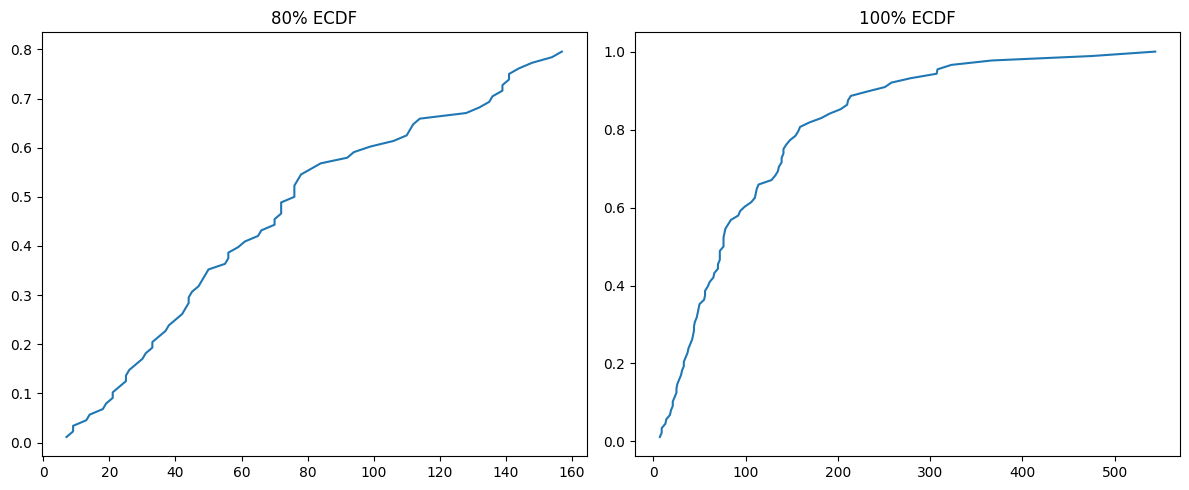

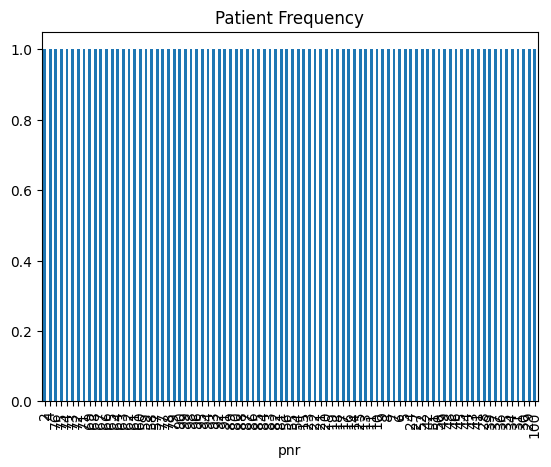

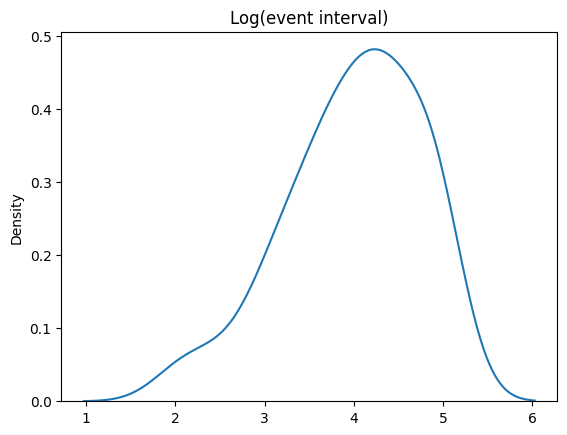

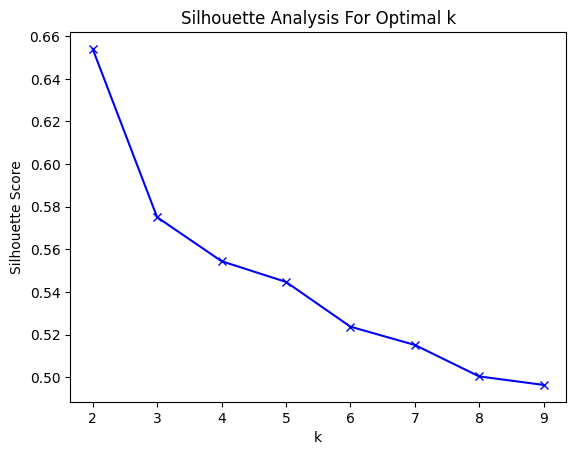

C:\Users\andre\AppData\Local\Temp\ipykernel_3416\178209421.py:113: FutureWarning: The provided callable <function min at 0x0000022EFF23A8C0> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  cluster_stats = dfper.groupby('cluster').agg({
C:\Users\andre\AppData\Local\Temp\ipykernel_3416\178209421.py:113: FutureWarning: The provided callable <function max at 0x0000022EFF23A7A0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  cluster_stats = dfper.groupby('cluster').agg({
C:\Users\andre\AppData\Local\Temp\ipykernel_3416\178209421.py:113: FutureWarning: The provided callable <function median at 0x0000022EFF36DC60> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current beh

,pnr,eksd,perday,ATC,dur_original,Median,Cluster
0,1,2033-04-26,4,medA,50,44.0,0.0
1,2,2036-01-20,4,medA,50,44.0,0.0
2,2,2036-03-10,4,medA,50,44.0,0.0
3,2,2036-08-01,4,medA,50,44.0,0.0
4,3,2042-04-13,4,medA,50,44.0,0.0
...,...,...,...,...,...,...,...
544,99,2031-11-08,4,medA,50,133.5,1.0
545,99,2032-06-16,4,medA,50,133.5,1.0
546,99,2032-09-18,4,medA,50,133.5,1.0
547,100,2032-08-05,2,medA,150,44.0,0.0


In [226]:
med_a = see_k_means("medA", med_events)
med_a

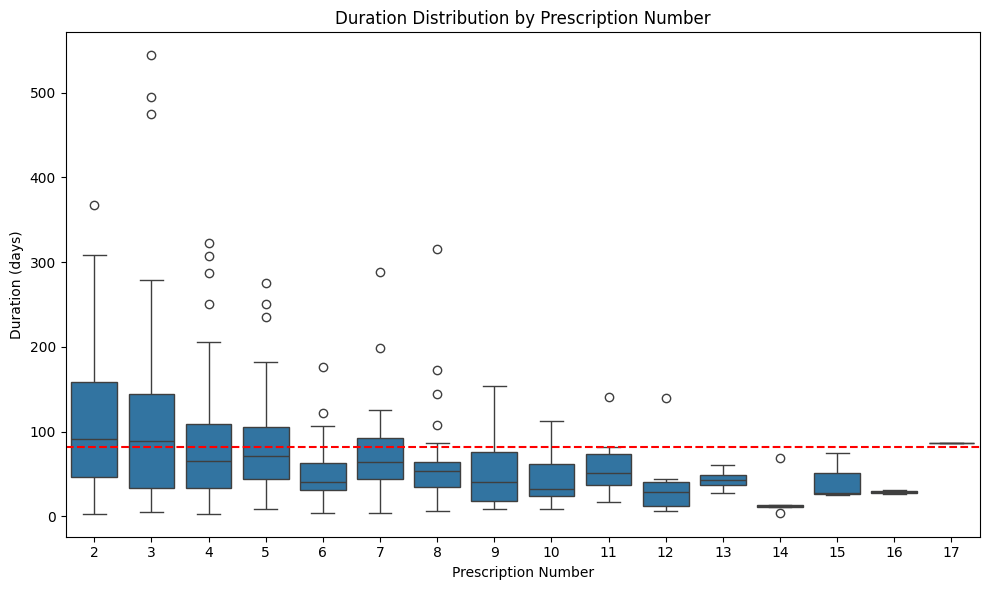

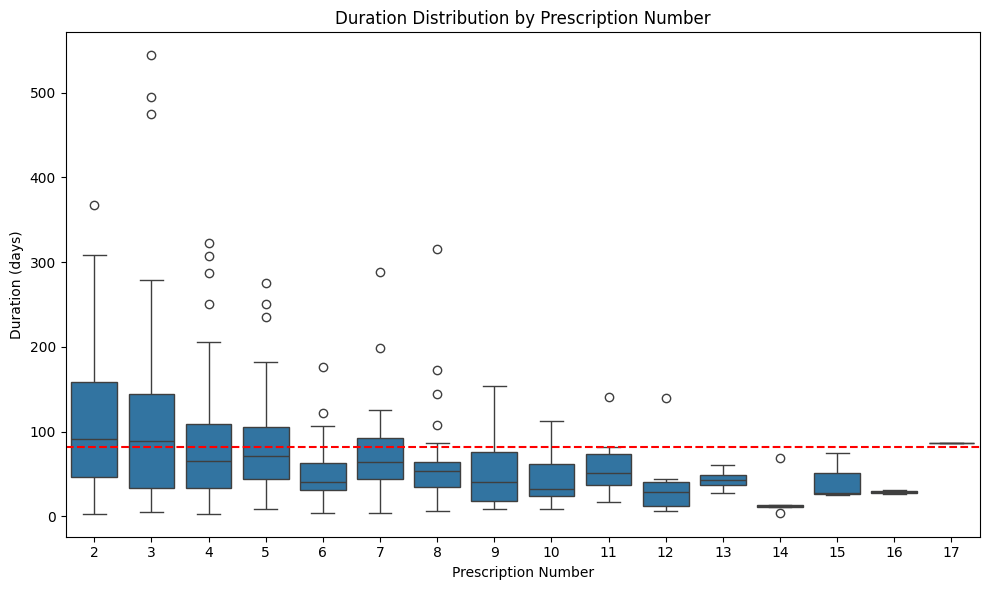

In [227]:
see_assumption(med_a)

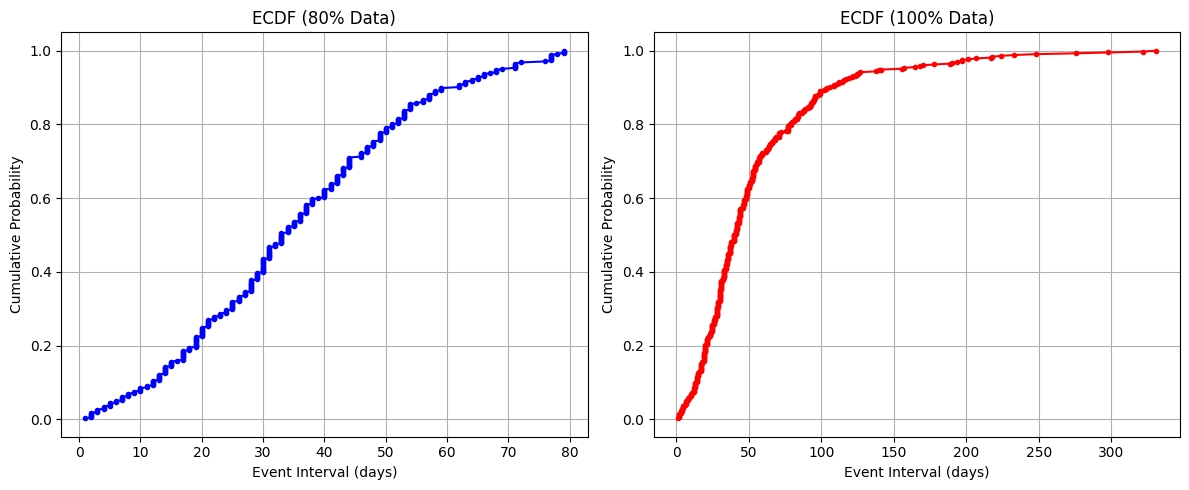

,pnr,eksd,perday,ATC,dur_original,prev_eksd,event_interval
2,1,2033-08-03,4,medB,30,2033-07-04,30
3,1,2033-08-17,4,medB,30,2033-08-03,14
4,1,2033-10-13,4,medB,30,2033-08-17,57
5,1,2033-10-16,4,medB,30,2033-10-13,3
6,1,2033-11-23,4,medB,30,2033-10-16,38
...,...,...,...,...,...,...,...
1075,100,2034-03-05,6,medB,30,2034-01-22,42
1076,100,2034-04-07,6,medB,30,2034-03-05,33
1077,100,2034-04-26,6,medB,30,2034-04-07,19
1078,100,2034-05-26,6,medB,30,2034-04-26,30


In [228]:
med_b = see("medB")
med_b

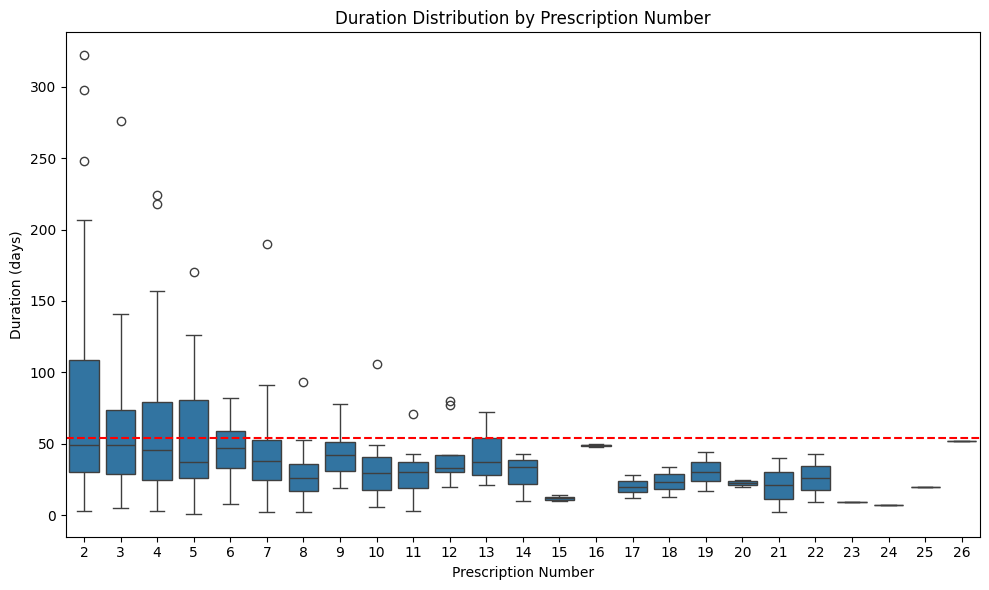

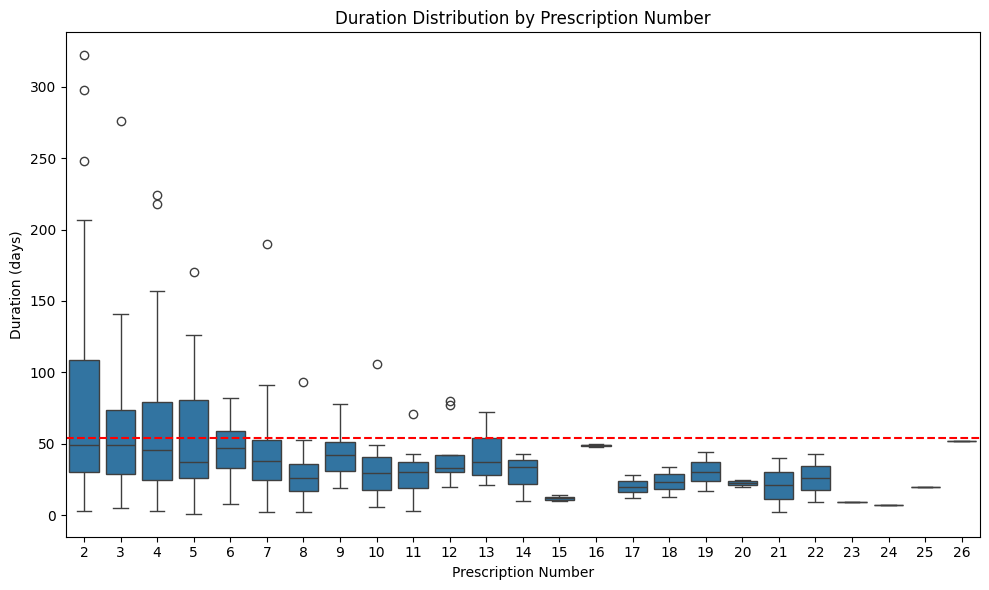

In [229]:
see_assumption(med_b)

### II. SEE Using **DBSCAN**

In [230]:
med_a_DB = see_dbscan("medA")
med_a_DB

,pnr,eksd,perday,ATC,dur_original,median,cluster
0,1,2033-04-26,4,medA,50,44.0,0.0
1,2,2036-01-20,4,medA,50,44.0,0.0
2,2,2036-03-10,4,medA,50,44.0,0.0
3,2,2036-08-01,4,medA,50,44.0,0.0
4,3,2042-04-13,4,medA,50,44.0,0.0
...,...,...,...,...,...,...,...
544,99,2031-11-08,4,medA,50,44.0,0.0
545,99,2032-06-16,4,medA,50,44.0,0.0
546,99,2032-09-18,4,medA,50,44.0,0.0
547,100,2032-08-05,2,medA,150,44.0,0.0


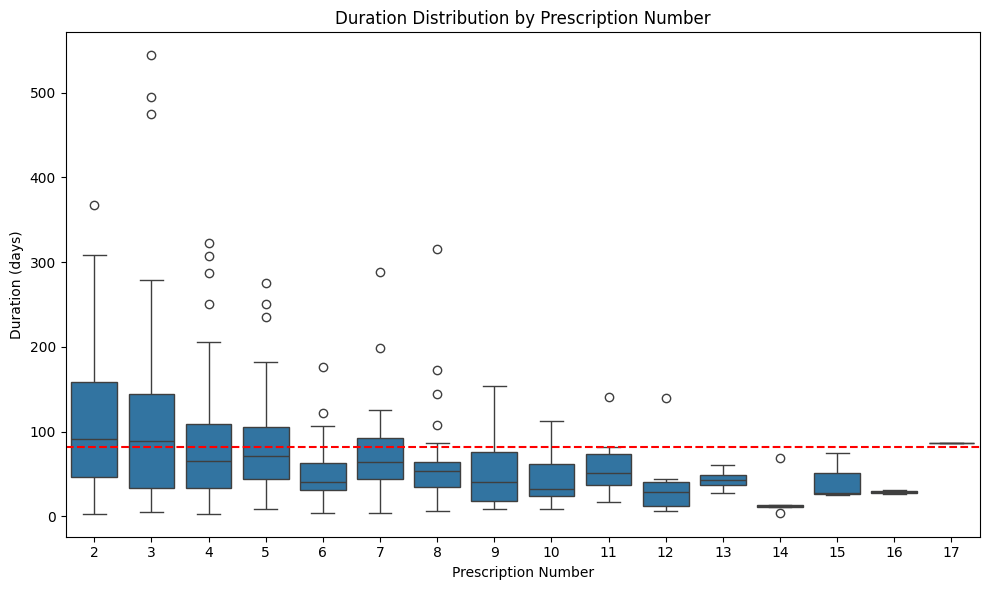

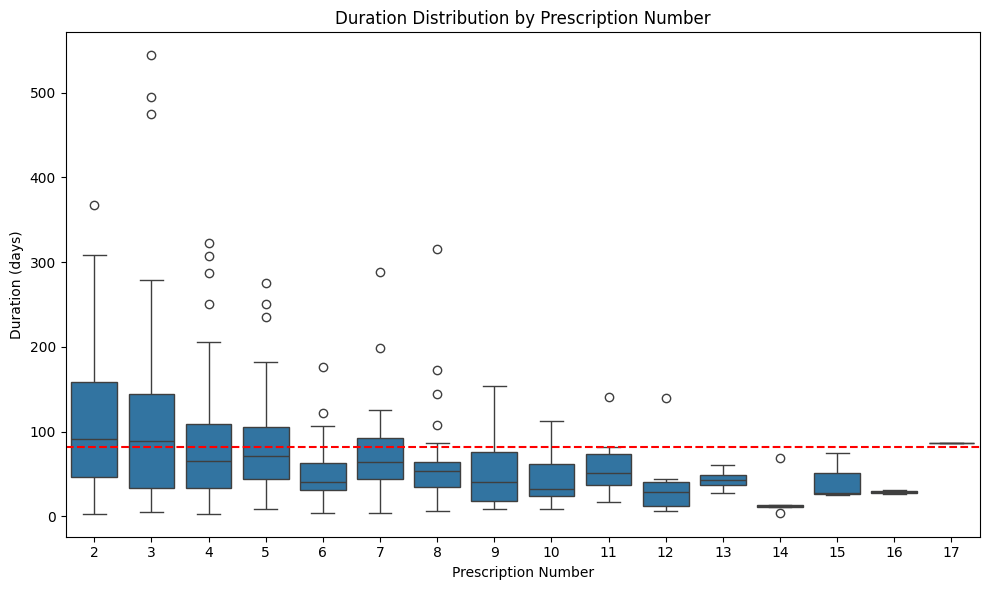

In [231]:
see_assumption(med_a_DB)

In [232]:
med_b_DB = see_dbscan("medB")
med_b_DB

,pnr,eksd,perday,ATC,dur_original,median,cluster
0,1,2033-07-04,4,medB,30,34.0,0.0
1,1,2033-08-03,4,medB,30,34.0,0.0
2,1,2033-08-17,4,medB,30,34.0,0.0
3,1,2033-10-13,4,medB,30,34.0,0.0
4,1,2033-10-16,4,medB,30,34.0,0.0
...,...,...,...,...,...,...,...
526,100,2034-03-05,6,medB,30,34.0,0.0
527,100,2034-04-07,6,medB,30,34.0,0.0
528,100,2034-04-26,6,medB,30,34.0,0.0
529,100,2034-05-26,6,medB,30,34.0,0.0


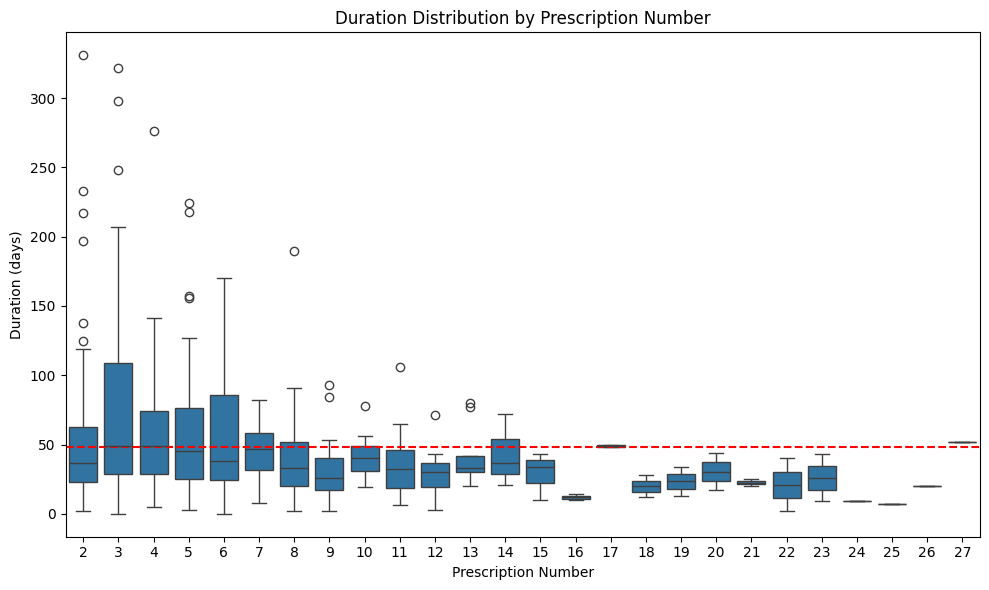

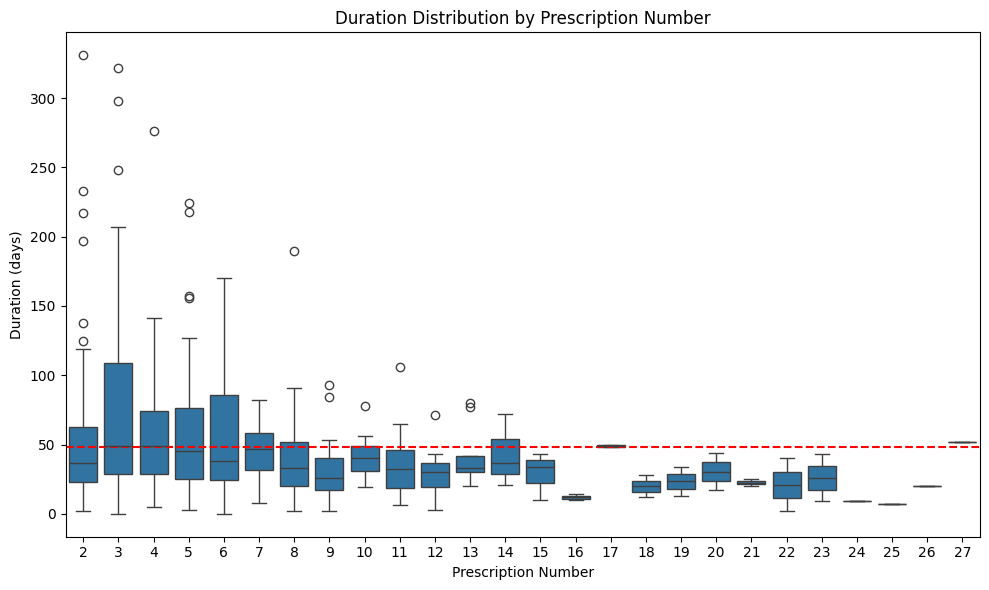

In [233]:
see_assumption(med_b_DB)


## **Comparison: SEE + KMeans vs. SEE + DBSCAN**

### **A. Early Prescription Variability**
#### **SEE + KMeans:**
- Early prescriptions (low p_number) show **wide refill interval distributions**.
- Some outliers extend **beyond 400–500 days** for medA and **~300 days** for medB.
- KMeans forces every data point into a cluster, potentially **blending irregular patterns** with typical ones.

#### **SEE + DBSCAN:**
- Similar early variability, but **DBSCAN isolates extreme refill outliers as noise**.
- More clearly differentiates between **patients with stable refill patterns and those with irregular behavior**.
- Results in a **sharper view of typical refill behavior** compared to KMeans.

### **B. Convergence in Later Prescriptions**
#### **SEE + KMeans:**
- **medA:** Stabilization around p_number **10**, with durations narrowing to **50–70 days**.
- **medB:** Convergence around p_number **15–20**, settling at **20–60 days**.
- Shows a **clear pattern of patients stabilizing refill behavior over time**.

#### **SEE + DBSCAN:**
- **medA:** Identifies up to **26 prescription events**, revealing more nuanced patterns.
- **medB:** Later refills show **similar stability**, but DBSCAN segments **subgroups within stable behavior**.
- Detects **subtle differences in refill consistency** beyond what KMeans reveals.

### **C. Differences Between medA and medB**
#### **Number of Prescriptions (Boxplots)**
- **KMeans:**
  - medA: **Up to 17** prescriptions observed.
  - medB: **Up to 27**, indicating longer treatment or frequent refills.
- **DBSCAN:**
  - medA: **Detects 26 prescription events**, uncovering **hidden refill patterns**.
  - medB: Similar number of refills as KMeans but **better noise filtering**.

#### **Duration Ranges & Median Refill Intervals**
- **KMeans:**
  - medA: Outliers reach **500 days early on**, stabilizing to **~50–60 days** later.
  - medB: Outliers up to **300 days**, stabilizing to **~30–40 days**.
- **DBSCAN:**
  - Excludes extreme outliers as noise, refining the typical refill patterns.
  - medB median remains **~30–40 days**, but DBSCAN isolates **clusters with different refill behaviors**.

### **D. Key Insights & Implications**
#### **Early Refill Irregularity**
- Both methods confirm **high variability in early refills**.
- **KMeans** blends outliers into clusters, while **DBSCAN isolates them as noise**, giving a clearer picture of adherence issues.

#### **Stabilization Over Time**
- Refill intervals become more predictable as p_number increases.
- **DBSCAN provides finer stratification**, revealing **subtle differences in long-term refill behaviors**.

#### **Different Refill Patterns by Medication**
- **medA:** DBSCAN identifies more **granular refill clusters**, suggesting **complex refill patterns**.
- **medB:** Fewer refills overall but **higher early variability**, requiring different adherence strategies.

#### **Clinical & Operational Implications**
- **For KMeans:** Useful for a **generalized, structured view of refill trends**.
- **For DBSCAN:** Detects **irregular patterns and adherence risks**, making it useful for **early intervention strategies**.
- **Tailored interventions**: DBSCAN’s noise filtering could help identify patients who need **reminders, counseling, or support**.

### **Final Thoughts**
- **SEE + KMeans** is better for a **simplified, fixed-cluster view** of refill behavior.
- **SEE + DBSCAN** provides **richer segmentation** by isolating **outliers and subtle subgroups**.
- **Choice depends on whether simplicity or detailed adherence patterns are the priority**.
